# Descrição do Problema

O conjunto de dados em questão foi disponibilizado pelo Banco Santander em uma competição no site Kaggle. O problema consiste em identificar a partir das variáveis quais clientes estão insatisfeitos e são propensos a deixar o Banco. O conjunto de dados é completamente anonimizado.

Link para a competição no Kaggle: __[Santander Customer Satisfactions](https://www.kaggle.com/c/santander-customer-satisfaction)__

## 1. Primeiros Passos

Inicialmente, importaremos as bibliotecas necessárias e carregaremos os dados na memória.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 4)
plt.style.use('ggplot')

In [2]:
train_df = pd.read_csv("data/train.csv")
train_df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [3]:
print('INFORMAÇÕES INICIAIS')
print(f'O conjunto de dados apresenta {len(train_df)} amostras e {len(train_df.columns)} colunas, divididas em:')
print(f'    - {len(train_df.select_dtypes(include= np.int64).columns)} colunas de dados inteiros')
print(f'    - {len(train_df.select_dtypes(include= np.float64).columns)} colunas de dados contínuos')
print(f'    - {len(train_df.select_dtypes(include= object).columns)} colunas de dados não-numéricos')
print(f'    - {len(train_df.select_dtypes(include= bool).columns)} colunas de dados booleanos')

INFORMAÇÕES INICIAIS
O conjunto de dados apresenta 76020 amostras e 371 colunas, divididas em:
    - 260 colunas de dados inteiros
    - 111 colunas de dados contínuos
    - 0 colunas de dados não-numéricos
    - 0 colunas de dados booleanos


Com 371 colunas, precisaremos focar grande parte de análise na escolha e engenharia de features, uma vez que esse número está muito alto paraa modelos de Machine Learning.

## 1.1 Análise da coluna alvo

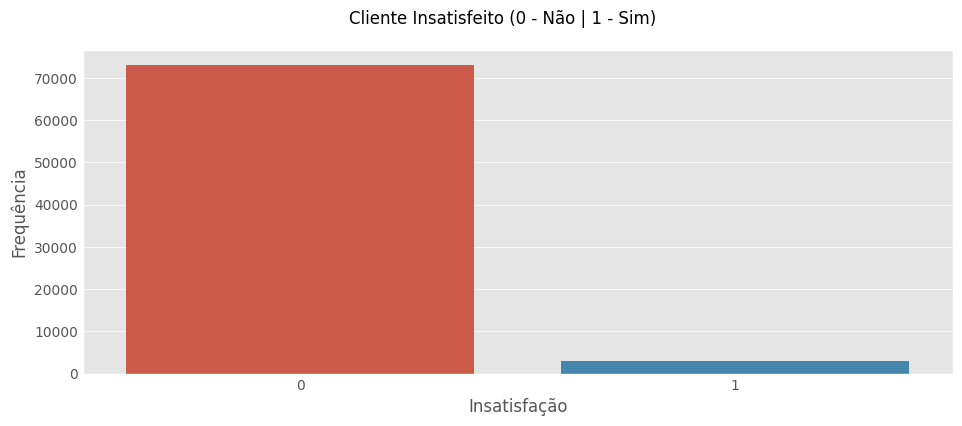

In [24]:
sns.countplot(data=train_df, x='TARGET')
plt.xlabel("Insatisfação")
plt.ylabel("Frequência")
plt.suptitle("Cliente Insatisfeito (0 - Não | 1 - Sim)")
plt.show()

Podemos ver que há um número muito maior de clientes satisfeitos na base de dados, ou seja, o conjunto é desbalanceado. Vamos analisar numericamente:

In [44]:
l = list(train_df.TARGET.value_counts())
p = [round(100*x/sum(l), 2) for x in l]
print("Conjunto de treino:")
print(f"Porcentagem de clientes satisfeitos: {p[0]}%")
print(f"Porcentagem de clientes insatisfeitos: {p[1]}%")

Conjunto de treino:
Porcentagem de clientes satisfeitos: 96.04%
Porcentagem de clientes insatisfeitos: 3.96%


Desse modo, devemos levar em consideração esse fato e aplicar técnicas de tratamento de dados desbalanceados.